In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from __future__ import absolute_import, division, print_function, unicode_literals
from six.moves import  urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Working with data

In [3]:
#Load dataset
dftrain = pd.read_csv('http://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('http://storage.googleapis.com/tf-datasets/titanic/eval.csv')
print(dftrain.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [4]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


In [5]:
print(y_train)

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64


In [6]:
print(dftrain.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [7]:
print(dftrain.loc[0], y_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [8]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [9]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [10]:
dftrain.shape

(627, 9)

In [11]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

<AxesSubplot:>

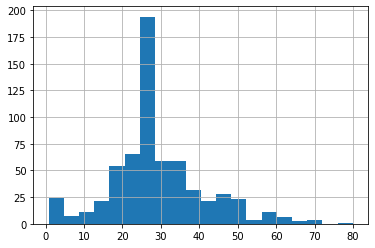

In [12]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

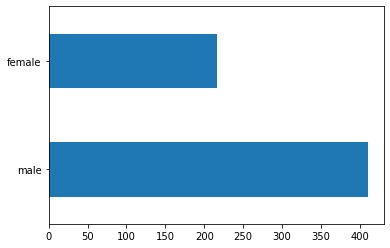

In [13]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

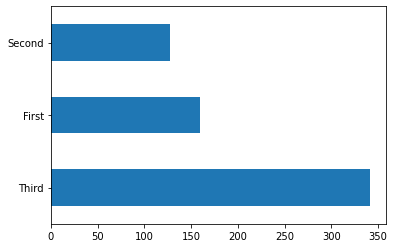

In [14]:
dftrain['class'].value_counts().plot(kind = 'barh')

Text(0.5, 0, '% survive')

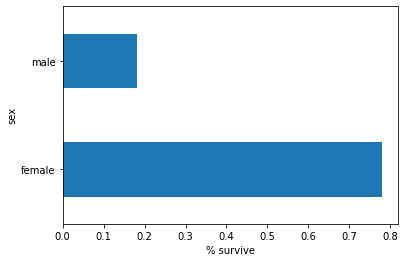

In [15]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Training and testing 

In [16]:
categorecal_columns = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numerical_columns = ['age','fare']
feature_columns = []
for feature_name in categorecal_columns :
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))


for feature_name in numerical_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))

print(feature_columns)


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [17]:
dftrain['n_siblings_spouses'].unique()

array([1, 0, 3, 4, 2, 5, 8])

# The Train Process

In [18]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle = True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000) #randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  #split dataset into batches of 32 and repeat process for number of epochs
    return ds #return a batch of the dataset
  return input_function  #return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

Training the model

In [20]:
linear_est.train(train_input_fn)  #train
result = linear_est.evaluate(eval_input_fn)  #get model metrics/stats by testing on testing data
clear_output() #clears consoke output
print(result['accuracy'])
print(result)

0.7348485
{'accuracy': 0.7348485, 'accuracy_baseline': 0.625, 'auc': 0.8340067, 'auc_precision_recall': 0.79412305, 'average_loss': 0.4772367, 'label/mean': 0.375, 'loss': 0.47112432, 'precision': 0.6407767, 'prediction/mean': 0.40543377, 'recall': 0.6666667, 'global_step': 200}


In [21]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[3])
print(y_eval.loc[3])
print(result[3]['probabilities'][1])

sex                        female
age                          55.0
n_siblings_spouses              0
parch                           0
fare                         16.0
class                      Second
deck                      unknown
embark_town           Southampton
alone                           y
Name: 3, dtype: object
1
0.68708116


# Classification

In [22]:
csv_column_names = ['SepalLength','SepalWidth','PetalLength','PetalWidth','Species']
species = ['Setose','Versicolor','Virginica']

In [23]:
train_path = tf.keras.utils.get_file(
    'iris_training.csv','https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv')
test_path = tf.keras.utils.get_file(
    'iris_test.csv','https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv')

train = pd.read_csv(train_path, names = csv_column_names, header = 0)
test = pd.read_csv(test_path, names = csv_column_names, header = 0)

573/573 [==============================] - 0s 0us/step


In [24]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [25]:
train.shape

(120, 5)

Input Functioon

In [26]:
train_y = train.pop('Species')
test_y = test.pop('Species')

def input_fn(features, labels, training=True, batch_size=256):
  #Convert the inputs to a dataset
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

  #shuffle and repeat if you are in training mode:
  if training:
    dataset = dataset.shuffle(1000).repeat()

  return dataset.batch(batch_size)

Feature Columns

In [27]:
#Feature columns describe how to use the input

my_feature_columns = []
for key in train.keys():
  my_feature_columns.append(tf.feature_column.numeric_column(key=key))

print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


# Building the Model

In [29]:
# Build a DNN(Deep Neural Network) with 2 hidden layers with 30 and 10 hidden nodes each
classifier = tf.estimator.DNNClassifier(
    feature_columns = my_feature_columns,
    #Two hidden layers of 30 and 10 nodes respectvely
    hidden_units=[30,10],
    #the model must choose between 3 classes.
    n_classes = 3)

Training

In [32]:
classifier.train(
    input_fn = lambda: input_fn(train, train_y, training = True),
    steps=5000
    # we include a lambda to avoid creating an inner function previously
    )

Evaluating

In [33]:
eval_result = classifier.evaluate(
    input_fn = lambda: input_fn(test, test_y, training = False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.967



Prediction

In [35]:
def input_fn(features, batch_size=256):
  #convert the input to a dataset without labels.
  return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength','SepalWidth','PetalLength','PetalWidth']
predict = {}  #predict dictionary

print('please print numeric values  as prompted')
for feature in features:
  valid = True
  while valid:
    val = input(feature +':')
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn = lambda: input_fn(predict))
for pred_dict in predictions: 
  class_id = pred_dict['class_ids'][0]
  probability = pred_dict['probabilities'][class_id]

  print('Prediction is "{}" ({:.1f}%)'.format(
      species[class_id],100*probability
  ))

please print numeric values  as prompted
SepalLength:9.6
SepalWidth:7.8
PetalLength:6.6
PetalWidth:7.8
Prediction is "Virginica" (95.6%)
